<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/MAFSwinTinyFrozenFocalLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frozen Swin-Tiny Modality Attention Fusion with Focal Loss**

As the unfrozen model did not perform as well as the frozen version, additional complexities were added to the forzen version. The first of these complexities added was Focal Loss.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Libraries**

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import Swinv2Model
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np


# **Defining Dataset, Classes, Weights, and Focal Loss**

In [ ]:
# Dataset
class PADUFESDataset(Dataset):
    def __init__(self, dataframe, img_dir, augment=True):
      self.skin_df = dataframe
      self.img_dir = img_dir
      self.augment = augment

      # Encode labels
      self.label_dict = {label: idx for idx, label in enumerate(sorted(self.skin_df['diagnostic'].unique()))}
      self.skin_df['label_encoded'] = self.skin_df['diagnostic'].map(self.label_dict)

      # Columns to exclude from metadata
      exclude_cols = [
          'img_id', 'diagnostic', 'patient_id', 'lesion_id',
          'folder', 'diagnostic_number', 'label_encoded'
      ]

      # Dynamically select all metadata columns
      self.metadata_cols = [col for col in self.skin_df.columns if col not in exclude_cols]

      # Fill missing values in metadata
      self.skin_df[self.metadata_cols] = self.skin_df[self.metadata_cols].fillna(0)

      # Transforms
      self.transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.RandomRotation(20),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
      ])

      self.base_transform = transforms.Compose([
          transforms.Resize((256, 256)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
      ])

      print("Using metadata columns:", self.metadata_cols)

    def __len__(self):
        return len(self.skin_df)

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 100
        while attempts < max_attempts:
            try:
                row = self.skin_df.iloc[idx]
                img_path = os.path.join(self.img_dir, row['img_id'])
                image = Image.open(img_path).convert("RGB")
                image = self.transform(image) if self.augment else self.base_transform(image)
                try:
                    metadata = torch.tensor(row[self.metadata_cols].astype(float).values, dtype=torch.float32)
                except Exception as e:
                    print("Error converting metadata row:", row[self.metadata_cols])
                    raise e

                label = row['label_encoded']
                return image, metadata, label

            except (FileNotFoundError, UnidentifiedImageError):
                attempts += 1
                idx = random.randint(0, len(self.skin_df) - 1)

        raise Exception(f"Failed to load image after {max_attempts} attempts.")

In [ ]:
# Balanced sampling
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.skin_df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.skin_df['label_encoded']]
    return weights

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super(ModalityAttentionFusion, self).__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)

        # Split weights
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)

        # Weighted fusion
        fused = img_alpha * img_feat + meta_alpha * meta_feat
        return fused

In [ ]:
# Multi-modal model
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super(MultiModalSwinClassifier, self).__init__()

        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, image, metadata):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)

        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)

        return self.classifier(fused)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total


In [ ]:
# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    loop = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# **Defining Model**

In [ ]:
# Paths
train_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
test_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"
img_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"
save_path = "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth"

In [ ]:
# Load CSVs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [ ]:
# Define metadata columns
exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
metadata_cols = [col for col in train_df.columns if col not in exclude_cols]

In [ ]:
# Apply StandardScaler
scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets and Loaders
train_ds = PADUFESDataset(train_df, img_dir)
test_ds = PADUFESDataset(test_df, img_dir, augment=False)

Using metadata columns: ['smoke_False', 'smoke_True', 'drink_False', 'drink_True', 'background_father_POMERANIA', 'background_father_GERMANY', 'background_father_BRAZIL', 'background_father_NETHERLANDS', 'background_father_ITALY', 'background_father_POLAND', 'background_father_UNK', 'background_father_PORTUGAL', 'background_father_BRASIL', 'background_father_CZECH', 'background_father_AUSTRIA', 'background_father_SPAIN', 'background_father_ISRAEL', 'background_mother_POMERANIA', 'background_mother_ITALY', 'background_mother_GERMANY', 'background_mother_BRAZIL', 'background_mother_UNK', 'background_mother_POLAND', 'background_mother_NORWAY', 'background_mother_PORTUGAL', 'background_mother_NETHERLANDS', 'background_mother_FRANCE', 'background_mother_SPAIN', 'age', 'pesticide_False', 'pesticide_True', 'gender_FEMALE', 'gender_MALE', 'skin_cancer_history_True', 'skin_cancer_history_False', 'cancer_history_True', 'cancer_history_False', 'has_piped_water_True', 'has_piped_water_False', 'has

In [ ]:
weights = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = MultiModalSwinClassifier(
    num_classes=len(train_ds.label_dict),
    metadata_dim=len(train_ds.metadata_cols)
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print("Label Dictionary:", train_ds.label_dict)

Label Dictionary: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}


In [ ]:
alpha = torch.tensor([1.0, 1.0, 2.0, 1.0, 4.0, 1.0]).to(device)

In [ ]:
# Training setup
criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

epochs = 25
patience = 10
best_val_acc = 0.0
epochs_no_improve = 0

# Track metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

lrs = []

# **Training Model**

In [ ]:
# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Training:   0%|          | 0/160 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Epoch 01 | Train Loss: 1.3821 | Val Loss: 1.1670 | Train Acc: 0.4292 | Val Acc: 0.3734
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 02 | Train Loss: 0.7241 | Val Loss: 0.8301 | Train Acc: 0.6522 | Val Acc: 0.3943
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 03 | Train Loss: 0.5385 | Val Loss: 0.7890 | Train Acc: 0.7117 | Val Acc: 0.5692
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 04 | Train Loss: 0.4249 | Val Loss: 0.7052 | Train Acc: 0.7645 | Val Acc: 0.6371
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 05 | Train Loss: 0.3474 | Val Loss: 0.6191 | Train Acc: 0.7990 | Val Acc: 0.6736
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 06 | Train Loss: 0.2617 | Val Loss: 0.7635 | Train Acc: 0.8491 | Val Acc: 0.6214


Epoch 07 | Train Loss: 0.2766 | Val Loss: 0.4967 | Train Acc: 0.8355 | Val Acc: 0.6554


Epoch 08 | Train Loss: 0.2333 | Val Loss: 0.6376 | Train Acc: 0.8559 | Val Acc: 0.7520
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 09 | Train Loss: 0.2032 | Val Loss: 0.5113 | Train Acc: 0.8773 | Val Acc: 0.7546
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 10 | Train Loss: 0.1915 | Val Loss: 0.5582 | Train Acc: 0.8830 | Val Acc: 0.7676
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 11 | Train Loss: 0.1532 | Val Loss: 0.6406 | Train Acc: 0.9070 | Val Acc: 0.8094
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 12 | Train Loss: 0.1957 | Val Loss: 0.5779 | Train Acc: 0.8799 | Val Acc: 0.6971


Epoch 13 | Train Loss: 0.1056 | Val Loss: 0.6703 | Train Acc: 0.9253 | Val Acc: 0.8172
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 14 | Train Loss: 0.1198 | Val Loss: 0.7492 | Train Acc: 0.9227 | Val Acc: 0.7258


Epoch 15 | Train Loss: 0.1110 | Val Loss: 0.7226 | Train Acc: 0.9290 | Val Acc: 0.7833


Epoch 16 | Train Loss: 0.1237 | Val Loss: 0.6990 | Train Acc: 0.9206 | Val Acc: 0.7232


Epoch 17 | Train Loss: 0.0794 | Val Loss: 0.7289 | Train Acc: 0.9483 | Val Acc: 0.7990


Epoch 18 | Train Loss: 0.0506 | Val Loss: 0.7511 | Train Acc: 0.9614 | Val Acc: 0.8381
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 19 | Train Loss: 0.0440 | Val Loss: 0.8195 | Train Acc: 0.9666 | Val Acc: 0.8094


Epoch 20 | Train Loss: 0.0403 | Val Loss: 0.8568 | Train Acc: 0.9681 | Val Acc: 0.8251


Epoch 21 | Train Loss: 0.0361 | Val Loss: 0.8116 | Train Acc: 0.9728 | Val Acc: 0.8251


Epoch 22 | Train Loss: 0.0233 | Val Loss: 0.7786 | Train Acc: 0.9828 | Val Acc: 0.8251


Epoch 23 | Train Loss: 0.0210 | Val Loss: 0.8282 | Train Acc: 0.9859 | Val Acc: 0.8433
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/swin_tiny_maf_fl_25_epochs.pth


Epoch 24 | Train Loss: 0.0132 | Val Loss: 0.9057 | Train Acc: 0.9927 | Val Acc: 0.8433


Epoch 25 | Train Loss: 0.0110 | Val Loss: 0.9274 | Train Acc: 0.9911 | Val Acc: 0.8407


# **Evaluation**

In [ ]:
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]

In [ ]:
# Load best model
model.load_state_dict(torch.load(save_path))
model.to(device)

val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)


Classification Report:
               precision    recall  f1-score   support

         ACK       0.93      0.88      0.90       122
         BCC       0.83      0.90      0.86       141
         MEL       0.80      0.89      0.84         9
         NEV       0.92      0.90      0.91        40
         SCC       0.47      0.50      0.48        32
         SEK       0.91      0.74      0.82        39

    accuracy                           0.84       383
   macro avg       0.81      0.80      0.80       383
weighted avg       0.85      0.84      0.84       383



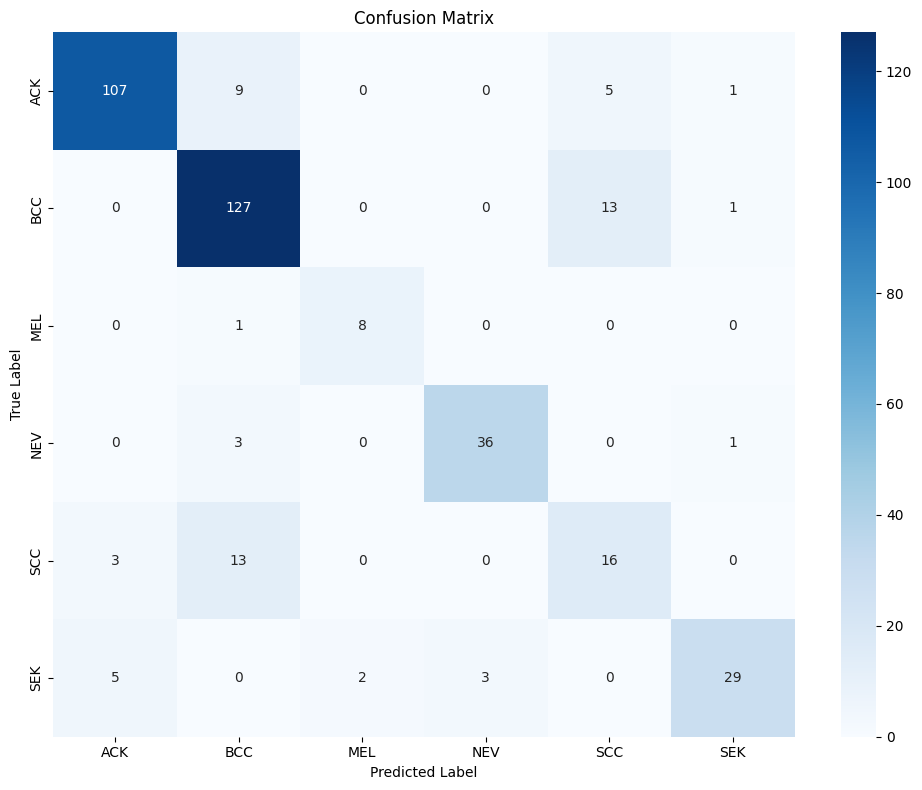

In [ ]:
val_preds = [int(p) for p in val_preds]
val_labels = [int(l) for l in val_labels]

# Classification report
report = classification_report(val_labels, val_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()